In [1]:
from langgraph.graph import StateGraph, END
from query_handler import query_documents
from re_ranker import ranker

/Users/harshilgohil/python/Langgraph/Agentic_RAG/langenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# State definition
class QAState(dict):
    question: str
    documents: list
    answer: str
    metrics: dict
    attempts: int


# Nodes
def retrieve_node(state: QAState):
    docs = query_documents(state["question"],persist_directory="./chroma_db", collection_name="pdf_collection",k=5)
    print("Chroma searched para : ",end="\n\n")
    print(docs)
    return {**state, "documents": docs}


def rerank_node(state: QAState):
    docs = ranker(state["question"], state["documents"])
    return {**state, "documents": docs}


def generate_node(state: QAState):
    context = "\n\n".join([f"{d}" for d in state["documents"]])
    prompt = f"Answer strictly from the following documents:\n{context}\n\nQ: {state['question']}\nA:"
    response = llm.invoke(prompt)
    return {**state, "answer": response.content}


def self_check_node(state: QAState):
    judge_prompt = f"Does the answer below stay grounded in the provided documents? Answer YES/NO. \n\n Documents: {state['documents']} \n\nAnswer: {state['answer']}"
    judge = llm.invoke(judge_prompt)
    grounded = "YES" in judge.content.upper()
    return {**state, "metrics": {"grounded": grounded}, "attempts": state.get("attempts", 0) + 1}

In [3]:
workflow = StateGraph(QAState)
workflow.add_node("retrieve", retrieve_node)
workflow.add_node("rerank", rerank_node)
workflow.add_node("generate", generate_node)
workflow.add_node("self_check", self_check_node)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "rerank")
workflow.add_edge("rerank", "generate")
workflow.add_edge("generate", "self_check")

def conditional(state: QAState):
    if not state["metrics"]["grounded"] and state["attempts"] < 2:
        return "retrieve"
    return END   

workflow.add_conditional_edges("self_check", conditional, {"retrieve": "retrieve", END: END})
graph = workflow.compile()

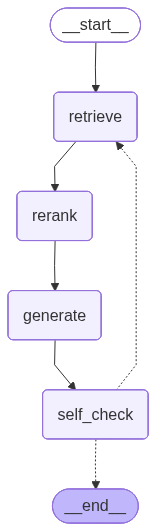

In [4]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))